# NIFTY BANK Stock Analysis using Support & Resistance Strategy

In [1]:
!pip install yfinance
!pip install mplfinance
!pip install mplcursors

## Importing the required libraries:

In [2]:
import pandas as pd
import numpy as np
import yfinance
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import mplcursors

## Setting the plot configuration:

In [3]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

## Retrieving stock price data using the yfinance library:

In [4]:
name = '^NSEBANK'  # NIFTY BANK index symbol
ticker = yfinance.Ticker(name)
df = ticker.history(interval="1d", start="2023-02-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'))

## Preparing the data for plotting:

In [5]:
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Added Volume column

## Defining functions to identify support and resistance levels:

In [6]:
def isSupport(df, i):
    support = df['Low'][i] < df['Low'][i-1] and df['Low'][i] < df['Low'][i+1] and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
    return support

In [7]:
def isResistance(df, i):
    resistance = df['High'][i] > df['High'][i-1] and df['High'][i] > df['High'][i+1] and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2]
    return resistance

## Identifying support and resistance levels and storing them in the levels list:

In [8]:
levels = []
for i in range(2, df.shape[0]-2):
    if isSupport(df, i):
        levels.append((i, df['Low'][i], 'Support'))
    elif isResistance(df, i):
        levels.append((i, df['High'][i], 'Resistance'))

## Calculating the average price range (s) and filtering out levels that are close to each other:

In [9]:
s = np.mean(df['High'] - df['Low'])

In [10]:
def isFarFromLevel(l):
    return np.sum([abs(l-x[1]) < s for x in levels]) == 0

In [11]:
levels = []
for i in range(2, df.shape[0]-2):
    if isSupport(df, i):
        l = df['Low'][i]
        if isFarFromLevel(l):
            levels.append((i, l, 'Support'))
    elif isResistance(df, i):
        l = df['High'][i]
        if isFarFromLevel(l):
            levels.append((i, l, 'Resistance'))



## Defining a function to find potential entry points for trading:

In [12]:
def find_entry_points():
    entry_points = []
    for i in range(1, len(levels)-1):
        curr_level = levels[i]
        prev_level = levels[i-1]
        next_level = levels[i+1]

        if curr_level[1] < prev_level[1] and curr_level[1] < next_level[1]:
            entry_points.append(curr_level[0])

    return entry_points



## Defining a function to plot the stock price chart with support, resistance levels, and entry points:

In [13]:
def plot_all():
    
    # Plotting the candlestick chart
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, df.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    ax.xaxis.set_tick_params(rotation=45)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Stock Price')
    fig.autofmt_xdate()
    fig.tight_layout()
    
    # Plotting support and resistance levels
    for level in levels:
        plt.hlines(level[1], xmin=df['Date'][level[0]], xmax=max(df['Date']), colors='blue', linewidth=0.5)
        plt.text(df['Date'][level[0]], level[1], level[2], ha='center', va='bottom', color='black')
        price = df['Close'][level[0]]
        volume = df['Volume'][level[0]]  # Added Volume
        plt.annotate(f'Price: {price:.2f}', (df['Date'][level[0]], level[1]), xytext=(5, -15),
                     textcoords='offset points', ha='right', color='black', size=8)  # Updated annotation for price
        plt.annotate(f'Volume: {volume:.0f}', (df['Date'][level[0]], level[1]), xytext=(5, -30),
                     textcoords='offset points', ha='right', color='black', size=8)  # Added annotation for volume

    # Plotting entry points
    entry_points = find_entry_points()
    for entry_point in entry_points:
        plt.scatter(df['Date'][entry_point], df['Low'][entry_point], color='green', marker='o', s=100)
        plt.annotate('Time to Enter Trade', (df['Date'][entry_point], df['Low'][entry_point]), xytext=(15, -25),
                     textcoords='offset points', ha='left', color='white', size=10, backgroundcolor='purple', weight='bold',
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='green'))

    mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(f"Price: {sel.target[1]:.2f}"))  # Updated annotation
    plt.show()


## Calling the plot_all() function to generate the plot:

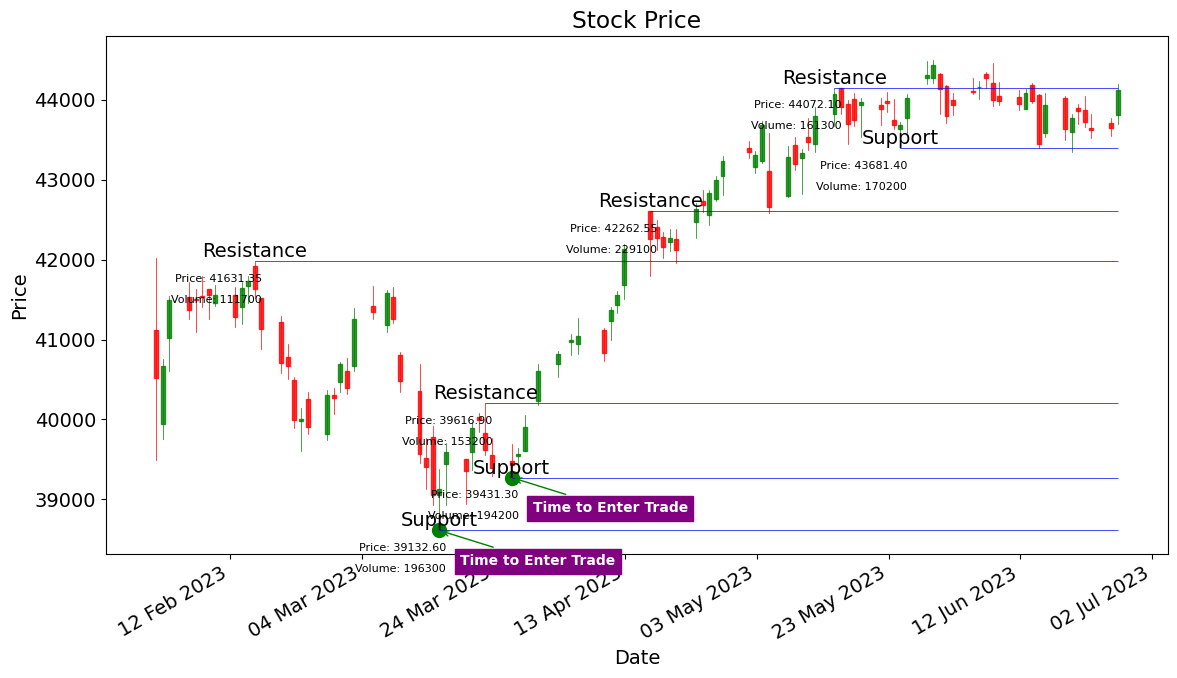

In [14]:
plot_all()

                                                                                                                        
Note: The resulting plot shows the stock's candlestick chart with support and resistance levels indicated by blue lines. Entry points for potential trades are marked with green dots and annotations. The annotations include the price and volume information at each level. Additionally, hovering over the chart will display the price information using the mplcursors library.